# Video prediction with SAM 3

## 1. Setup

In [1]:
import sys

sam3_root = "/home/kalyanv/sam3"
sys.path.append(f"{sam3_root}/examples")

checkpoint_file = f"{sam3_root}/assets/checkpoints/sam3_video_model_only.pt"
has_presence_token = True
geo_encoder_use_img_cross_attn = True

In [3]:
import torch

# use all available GPUs on the machine
gpus_to_use = range(torch.cuda.device_count())

# # use only a single GPU
# gpus_to_use = [torch.cuda.current_device()]

In [4]:
from sam3.model.sam3_video_predictor import Sam3VideoPredictorMultiGPU

predictor = Sam3VideoPredictorMultiGPU(
    checkpoint_path=checkpoint_file,
    has_presence_token=has_presence_token,
    geo_encoder_use_img_cross_attn=geo_encoder_use_img_cross_attn,
    gpus_to_use=gpus_to_use,
)

INFO 2025-10-09 19:18:18,976 45261 sam3_video_predictor.py: 286: using the following GPU IDs: [0, 1, 2, 3, 4, 5, 6, 7]
INFO 2025-10-09 19:18:18,978 45261 sam3_video_predictor.py: 302: 


	*** START loading model on all ranks ***


INFO 2025-10-09 19:18:18,979 45261 sam3_video_predictor.py: 304: loading model on rank=0 with world_size=8 -- this could take a while ...
INFO 2025-10-09 19:18:24,792 45261 sam3_video_base.py: 155: `setting max_num_objects` to 128 -- creating num_obj_for_compile=16 objects for torch.compile cache
INFO 2025-10-09 19:18:27,377 45261 sam3_video_predictor.py: 306: loading model on rank=0 with world_size=8 -- DONE locally
INFO 2025-10-09 19:18:27,378 45261 sam3_video_predictor.py: 363: spawning 7 worker processes
/storage/home/kalyanv/miniconda/envs/sam3/lib/python3.12/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecat

### Visualization utils

In [5]:
import os
import glob
import matplotlib.pyplot as plt
from utils import visualize_formatted_frame_output, prepare_masks_for_visualization

INFO 2025-10-09 19:19:03,897 45725 sam3_video_predictor.py: 416: started NCCL process group on rank=1 with world_size=8

Bad key keymap.all_axes in file /tmp/par_unpack.bento_cloud.168753.096461d0d1e948435d488359ec35137d/bento/server/matplotlibrc-3.1.3, line 76 ('keymap.all_axes : a                 # enable all axes')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.10.6/lib/matplotlib/mpl-data/matplotlibrc
or from the matplotlib source distribution


Converting 5000 RGB samples to LAB color space...
Conversion to LAB complete.
Fitting KMeans with 128 clusters on 5000 samples...


KMeans fitting complete.


## 2. Running inference

In [6]:
# this video has 6 objects
video_frames_dir = f"{sam3_root}/assets/videos/0001"
prompt_text_str = "person"

# this video has ~80 objects
# video_frames_dir = "/checkpoint/sam3/shared/webdemo/data/ta/static/gallery/selected_examples/0018/rgb"
# prompt_text_str = "horse"

In [7]:
# load "image_files" for visualization purposes (they are not used by the model)
image_files = glob.glob(os.path.join(video_frames_dir, "*.jpg"))
try:
    # integer sort instead of string sort (so that e.g. "2.jpg" is before "11.jpg")
    image_files.sort(key=lambda p: int(os.path.splitext(os.path.basename(p))[0]))
except ValueError:
    # fallback to lexicographic sort if the format is not "<frame_index>.jpg"
    print(
        f'frame names are not in "<frame_index>.jpg" format: {image_files[:5]=}, '
        f"falling back to lexicographic sort."
    )
    image_files.sort()

### Opening an inference session on this video

In [8]:
response = predictor.handle_request(
    request=dict(
        type="start_session",
        resource_path=video_frames_dir,
    )
)
session_id = response["session_id"]

Enabled the use of perflib.
Enabled the use of perflib.
Enabled the use of perflib.
Enabled the use of perflib.
Enabled the use of perflib.
Enabled the use of perflib.
Enabled the use of perflib.


INFO 2025-10-09 19:19:07,217 45725 sam3_video_predictor.py: 472: worker rank=1 received request request['type']='start_session'
INFO 2025-10-09 19:19:07,217 45731 sam3_video_predictor.py: 472: worker rank=7 received request request['type']='start_session'
INFO 2025-10-09 19:19:07,217 45728 sam3_video_predictor.py: 472: worker rank=4 received request request['type']='start_session'
INFO 2025-10-09 19:19:07,217 45729 sam3_video_predictor.py: 472: worker rank=5 received request request['type']='start_session'
INFO 2025-10-09 19:19:07,217 45726 sam3_video_predictor.py: 472: worker rank=2 received request request['type']='start_session'
INFO 2025-10-09 19:19:07,256 45730 sam3_video_predictor.py: 472: worker rank=6 received request request['type']='start_session'
INFO 2025-10-09 19:19:07,289 45727 sam3_video_predictor.py: 472: worker rank=3 received request request['type']='start_session'
frame loading (JPEG) [rank=3]:   0%|          | 0/270 [00:00<?, ?it/s]

frame loading (JPEG) [rank=0]:   0%|          | 0/270 [00:00<?, ?it/s]

frame loading (JPEG) [rank=6]:   1%|          | 2/270 [00:00<00:46,  5.83it/s]

frame loading (JPEG) [rank=4]:   1%|          | 3/270 [00:00<00:47,  5.65it/s]

frame loading (JPEG) [rank=5]:   2%|▏         | 5/270 [00:00<00:41,  6.34it/s]

frame loading (JPEG) [rank=4]:   2%|▏         | 6/270 [00:01<00:44,  5.91it/s]

frame loading (JPEG) [rank=3]:   3%|▎         | 7/270 [00:01<00:45,  5.81it/s]

frame loading (JPEG) [rank=6]:   3%|▎         | 9/270 [00:01<00:41,  6.22it/s]

frame loading (JPEG) [rank=4]:   4%|▎         | 10/270 [00:01<00:43,  6.02it/s]

frame loading (JPEG) [rank=5]:   4%|▍         | 12/270 [00:01<00:41,  6.15it/s]

frame loading (JPEG) [rank=6]:   5%|▍         | 13/270 [00:02<00:42,  6.07it/s]

frame loading (JPEG) [rank=5]:   6%|▌         | 15/270 [00:02<00:40,  6.36it/s]

frame loading (JPEG) [rank=6]:   6%|▌         | 16/270 [00:02<00:42,  6.02it/s]

frame loading (JPEG) [rank=2]:   6%|▋         | 17/270 [00:02<00:44,  5.66it/s]

frame loading (JPEG) [rank=5]:   7%|▋         | 19/270 [00:03<00:41,  6.00it/s]

frame loading (JPEG) [rank=1]:   7%|▋         | 19/270 [00:03<00:43,  5.79it/s]

frame loading (JPEG) [rank=4]:   8%|▊         | 21/270 [00:03<00:41,  6.00it/s]

frame loading (JPEG) [rank=1]:   8%|▊         | 22/270 [00:03<00:40,  6.07it/s]

frame loading (JPEG) [rank=7]:   9%|▉         | 24/270 [00:03<00:38,  6.34it/s]

frame loading (JPEG) [rank=2]:   9%|▉         | 25/270 [00:04<00:41,  5.89it/s]

frame loading (JPEG) [rank=7]:  10%|█         | 27/270 [00:04<00:36,  6.60it/s]

frame loading (JPEG) [rank=1]:  10%|█         | 27/270 [00:04<00:40,  6.03it/s]

frame loading (JPEG) [rank=7]:  11%|█         | 30/270 [00:04<00:37,  6.39it/s]

frame loading (JPEG) [rank=6]:  11%|█▏        | 31/270 [00:05<00:40,  5.95it/s]

frame loading (JPEG) [rank=3]:  12%|█▏        | 32/270 [00:05<00:37,  6.30it/s]

frame loading (JPEG) [rank=1]:  12%|█▏        | 32/270 [00:05<00:42,  5.55it/s]

frame loading (JPEG) [rank=6]:  13%|█▎        | 35/270 [00:05<00:37,  6.25it/s]

frame loading (JPEG) [rank=6]:  14%|█▎        | 37/270 [00:05<00:37,  6.20it/s]

frame loading (JPEG) [rank=1]:  13%|█▎        | 36/270 [00:06<00:40,  5.78it/s]

frame loading (JPEG) [rank=3]:  14%|█▍        | 39/270 [00:06<00:37,  6.12it/s]

frame loading (JPEG) [rank=2]:  15%|█▍        | 40/270 [00:06<00:38,  6.00it/s]

frame loading (JPEG) [rank=3]:  16%|█▌        | 42/270 [00:06<00:36,  6.25it/s]

frame loading (JPEG) [rank=6]:  16%|█▋        | 44/270 [00:07<00:37,  6.05it/s]

frame loading (JPEG) [rank=7]:  17%|█▋        | 45/270 [00:07<00:36,  6.20it/s]

frame loading (JPEG) [rank=2]:  17%|█▋        | 45/270 [00:07<00:37,  6.02it/s]

frame loading (JPEG) [rank=4]:  17%|█▋        | 47/270 [00:07<00:37,  5.91it/s]

frame loading (JPEG) [rank=5]:  18%|█▊        | 49/270 [00:07<00:38,  5.75it/s]

frame loading (JPEG) [rank=4]:  19%|█▊        | 50/270 [00:08<00:36,  5.99it/s]

frame loading (JPEG) [rank=5]:  19%|█▉        | 52/270 [00:08<00:37,  5.80it/s]

frame loading (JPEG) [rank=3]:  20%|█▉        | 53/270 [00:08<00:35,  6.10it/s]

frame loading (JPEG) [rank=4]:  20%|██        | 54/270 [00:08<00:36,  5.97it/s]

frame loading (JPEG) [rank=2]:  20%|██        | 55/270 [00:09<00:35,  6.06it/s]

frame loading (JPEG) [rank=4]:  21%|██        | 57/270 [00:09<00:35,  6.06it/s]

frame loading (JPEG) [rank=3]:  22%|██▏       | 59/270 [00:09<00:33,  6.22it/s]

frame loading (JPEG) [rank=5]:  22%|██▏       | 60/270 [00:09<00:36,  5.75it/s]

frame loading (JPEG) [rank=1]:  22%|██▏       | 60/270 [00:10<00:35,  5.97it/s]

frame loading (JPEG) [rank=7]:  23%|██▎       | 63/270 [00:10<00:35,  5.78it/s]

frame loading (JPEG) [rank=3]:  24%|██▎       | 64/270 [00:10<00:35,  5.75it/s]

frame loading (JPEG) [rank=1]:  24%|██▎       | 64/270 [00:10<00:34,  5.93it/s]

frame loading (JPEG) [rank=4]:  25%|██▍       | 67/270 [00:11<00:34,  5.90it/s]

frame loading (JPEG) [rank=3]:  25%|██▌       | 68/270 [00:11<00:35,  5.71it/s]

frame loading (JPEG) [rank=1]:  25%|██▌       | 68/270 [00:11<00:33,  6.08it/s]

frame loading (JPEG) [rank=4]:  26%|██▋       | 71/270 [00:11<00:33,  5.93it/s]

frame loading (JPEG) [rank=1]:  26%|██▋       | 71/270 [00:11<00:30,  6.51it/s]

frame loading (JPEG) [rank=2]:  27%|██▋       | 73/270 [00:12<00:32,  6.10it/s]

frame loading (JPEG) [rank=7]:  28%|██▊       | 75/270 [00:12<00:30,  6.30it/s]

frame loading (JPEG) [rank=4]:  28%|██▊       | 76/270 [00:12<00:31,  6.12it/s]

frame loading (JPEG) [rank=4]:  29%|██▉       | 78/270 [00:12<00:30,  6.28it/s]

frame loading (JPEG) [rank=1]:  29%|██▉       | 79/270 [00:13<00:30,  6.22it/s]

frame loading (JPEG) [rank=1]:  30%|██▉       | 80/270 [00:13<00:32,  5.92it/s]

frame loading (JPEG) [rank=5]:  30%|███       | 82/270 [00:13<00:30,  6.21it/s]

frame loading (JPEG) [rank=1]:  31%|███       | 83/270 [00:13<00:30,  6.11it/s]

frame loading (JPEG) [rank=5]:  31%|███▏      | 85/270 [00:14<00:29,  6.37it/s]

frame loading (JPEG) [rank=4]:  32%|███▏      | 87/270 [00:14<00:30,  6.10it/s]

frame loading (JPEG) [rank=1]:  32%|███▏      | 87/270 [00:14<00:31,  5.86it/s]

frame loading (JPEG) [rank=7]:  33%|███▎      | 90/270 [00:14<00:28,  6.35it/s]

frame loading (JPEG) [rank=1]:  33%|███▎      | 90/270 [00:14<00:29,  6.16it/s]

frame loading (JPEG) [rank=2]:  34%|███▎      | 91/270 [00:15<00:29,  5.97it/s]

frame loading (JPEG) [rank=5]:  34%|███▍      | 93/270 [00:15<00:30,  5.82it/s]

frame loading (JPEG) [rank=6]:  35%|███▌      | 95/270 [00:15<00:28,  6.12it/s]

frame loading (JPEG) [rank=3]:  35%|███▌      | 95/270 [00:15<00:28,  6.18it/s]

frame loading (JPEG) [rank=7]:  36%|███▋      | 98/270 [00:16<00:28,  6.06it/s]

frame loading (JPEG) [rank=2]:  36%|███▋      | 98/270 [00:16<00:27,  6.23it/s]

frame loading (JPEG) [rank=5]:  37%|███▋      | 100/270 [00:16<00:27,  6.24it/s]

frame loading (JPEG) [rank=1]:  37%|███▋      | 101/270 [00:16<00:28,  5.99it/s]

frame loading (JPEG) [rank=3]:  38%|███▊      | 102/270 [00:16<00:26,  6.35it/s]

frame loading (JPEG) [rank=5]:  39%|███▊      | 104/270 [00:17<00:26,  6.23it/s]

frame loading (JPEG) [rank=7]:  39%|███▉      | 106/270 [00:17<00:27,  6.00it/s]

frame loading (JPEG) [rank=5]:  40%|███▉      | 107/270 [00:17<00:27,  6.03it/s]

frame loading (JPEG) [rank=1]:  40%|████      | 108/270 [00:17<00:25,  6.42it/s]

frame loading (JPEG) [rank=6]:  41%|████      | 110/270 [00:18<00:26,  5.98it/s]

frame loading (JPEG) [rank=1]:  41%|████      | 111/270 [00:18<00:25,  6.27it/s]

frame loading (JPEG) [rank=2]:  41%|████▏     | 112/270 [00:18<00:25,  6.16it/s]

frame loading (JPEG) [rank=6]:  42%|████▏     | 114/270 [00:18<00:25,  6.10it/s]

frame loading (JPEG) [rank=1]:  43%|████▎     | 115/270 [00:19<00:25,  6.00it/s]

frame loading (JPEG) [rank=2]:  43%|████▎     | 116/270 [00:19<00:25,  5.97it/s]

frame loading (JPEG) [rank=7]:  44%|████▍     | 119/270 [00:19<00:24,  6.29it/s]

frame loading (JPEG) [rank=1]:  44%|████▍     | 119/270 [00:19<00:25,  5.96it/s]

frame loading (JPEG) [rank=6]:  45%|████▍     | 121/270 [00:19<00:24,  6.17it/s]

frame loading (JPEG) [rank=5]:  45%|████▌     | 122/270 [00:20<00:23,  6.24it/s]

frame loading (JPEG) [rank=6]:  46%|████▌     | 124/270 [00:20<00:23,  6.15it/s]

frame loading (JPEG) [rank=3]:  46%|████▌     | 124/270 [00:20<00:24,  6.00it/s]

frame loading (JPEG) [rank=7]:  47%|████▋     | 127/270 [00:20<00:24,  5.88it/s]

frame loading (JPEG) [rank=4]:  47%|████▋     | 128/270 [00:21<00:23,  6.16it/s]

frame loading (JPEG) [rank=7]:  48%|████▊     | 130/270 [00:21<00:22,  6.09it/s]

frame loading (JPEG) [rank=6]:  49%|████▊     | 131/270 [00:21<00:20,  6.76it/s]

frame loading (JPEG) [rank=5]:  49%|████▉     | 132/270 [00:21<00:22,  6.21it/s]

frame loading (JPEG) [rank=3]:  49%|████▉     | 132/270 [00:22<00:24,  5.75it/s]

frame loading (JPEG) [rank=1]:  50%|████▉     | 134/270 [00:22<00:23,  5.67it/s]

frame loading (JPEG) [rank=6]:  51%|█████     | 137/270 [00:22<00:22,  5.94it/s]

frame loading (JPEG) [rank=3]:  50%|█████     | 136/270 [00:22<00:21,  6.10it/s]

frame loading (JPEG) [rank=5]:  51%|█████▏    | 139/270 [00:22<00:20,  6.48it/s]

frame loading (JPEG) [rank=6]:  52%|█████▏    | 141/270 [00:23<00:21,  5.95it/s]

frame loading (JPEG) [rank=1]:  52%|█████▏    | 141/270 [00:23<00:21,  6.06it/s]

frame loading (JPEG) [rank=2]:  53%|█████▎    | 143/270 [00:23<00:20,  6.08it/s]

frame loading (JPEG) [rank=2]:  53%|█████▎    | 144/270 [00:23<00:22,  5.67it/s]

frame loading (JPEG) [rank=5]:  54%|█████▍    | 146/270 [00:24<00:19,  6.25it/s]

frame loading (JPEG) [rank=1]:  54%|█████▍    | 146/270 [00:24<00:21,  5.78it/s]

frame loading (JPEG) [rank=6]:  55%|█████▌    | 149/270 [00:24<00:20,  5.99it/s]

frame loading (JPEG) [rank=4]:  56%|█████▌    | 151/270 [00:24<00:18,  6.40it/s]

frame loading (JPEG) [rank=2]:  56%|█████▌    | 151/270 [00:24<00:18,  6.41it/s]

frame loading (JPEG) [rank=6]:  57%|█████▋    | 153/270 [00:25<00:20,  5.85it/s]

frame loading (JPEG) [rank=7]:  57%|█████▋    | 155/270 [00:25<00:19,  5.89it/s]

frame loading (JPEG) [rank=2]:  57%|█████▋    | 155/270 [00:25<00:19,  5.99it/s]

frame loading (JPEG) [rank=5]:  58%|█████▊    | 157/270 [00:25<00:18,  6.17it/s]

frame loading (JPEG) [rank=4]:  59%|█████▉    | 159/270 [00:26<00:19,  5.84it/s]

frame loading (JPEG) [rank=6]:  59%|█████▉    | 160/270 [00:26<00:17,  6.37it/s]

frame loading (JPEG) [rank=1]:  59%|█████▉    | 160/270 [00:26<00:17,  6.20it/s]

frame loading (JPEG) [rank=3]:  59%|█████▉    | 160/270 [00:26<00:17,  6.20it/s]

frame loading (JPEG) [rank=2]:  60%|██████    | 163/270 [00:26<00:17,  6.02it/s]

frame loading (JPEG) [rank=1]:  61%|██████    | 164/270 [00:27<00:17,  6.22it/s]

frame loading (JPEG) [rank=1]:  61%|██████    | 165/270 [00:27<00:17,  6.04it/s]

frame loading (JPEG) [rank=7]:  62%|██████▏   | 168/270 [00:27<00:16,  6.08it/s]

frame loading (JPEG) [rank=1]:  62%|██████▏   | 168/270 [00:27<00:16,  6.23it/s]

frame loading (JPEG) [rank=7]:  63%|██████▎   | 171/270 [00:28<00:15,  6.26it/s]

frame loading (JPEG) [rank=2]:  63%|██████▎   | 171/270 [00:28<00:17,  5.79it/s]

frame loading (JPEG) [rank=1]:  64%|██████▎   | 172/270 [00:28<00:16,  5.88it/s]

frame loading (JPEG) [rank=3]:  64%|██████▍   | 173/270 [00:28<00:16,  5.98it/s]

frame loading (JPEG) [rank=4]:  65%|██████▌   | 176/270 [00:28<00:16,  5.67it/s]

frame loading (JPEG) [rank=1]:  65%|██████▌   | 176/270 [00:29<00:15,  6.10it/s]

frame loading (JPEG) [rank=3]:  66%|██████▌   | 177/270 [00:29<00:14,  6.22it/s]

frame loading (JPEG) [rank=1]:  66%|██████▋   | 179/270 [00:29<00:14,  6.43it/s]

frame loading (JPEG) [rank=6]:  67%|██████▋   | 181/270 [00:29<00:15,  5.88it/s]

frame loading (JPEG) [rank=1]:  67%|██████▋   | 182/270 [00:30<00:13,  6.29it/s]

frame loading (JPEG) [rank=4]:  68%|██████▊   | 184/270 [00:30<00:14,  5.78it/s]

frame loading (JPEG) [rank=4]:  69%|██████▊   | 185/270 [00:30<00:14,  5.88it/s]

frame loading (JPEG) [rank=6]:  69%|██████▉   | 186/270 [00:30<00:15,  5.55it/s]

frame loading (JPEG) [rank=2]:  69%|██████▉   | 187/270 [00:30<00:13,  6.24it/s]

frame loading (JPEG) [rank=5]:  70%|███████   | 189/270 [00:31<00:14,  5.77it/s]

frame loading (JPEG) [rank=7]:  71%|███████   | 191/270 [00:31<00:12,  6.38it/s]

frame loading (JPEG) [rank=1]:  71%|███████   | 191/270 [00:31<00:13,  5.76it/s]

frame loading (JPEG) [rank=6]:  71%|███████▏  | 193/270 [00:31<00:12,  6.26it/s]

frame loading (JPEG) [rank=1]:  72%|███████▏  | 194/270 [00:32<00:12,  5.90it/s]

frame loading (JPEG) [rank=5]:  73%|███████▎  | 196/270 [00:32<00:12,  5.79it/s]

frame loading (JPEG) [rank=4]:  73%|███████▎  | 198/270 [00:32<00:12,  5.77it/s]

frame loading (JPEG) [rank=3]:  73%|███████▎  | 198/270 [00:32<00:11,  6.04it/s]

frame loading (JPEG) [rank=2]:  74%|███████▍  | 200/270 [00:33<00:12,  5.77it/s]

frame loading (JPEG) [rank=6]:  75%|███████▍  | 202/270 [00:33<00:11,  6.07it/s]

frame loading (JPEG) [rank=4]:  76%|███████▌  | 204/270 [00:33<00:10,  6.47it/s]

frame loading (JPEG) [rank=2]:  76%|███████▌  | 204/270 [00:33<00:10,  6.21it/s]

frame loading (JPEG) [rank=5]:  76%|███████▋  | 206/270 [00:33<00:10,  6.12it/s]

frame loading (JPEG) [rank=1]:  77%|███████▋  | 207/270 [00:34<00:10,  5.98it/s]

frame loading (JPEG) [rank=2]:  77%|███████▋  | 208/270 [00:34<00:10,  5.86it/s]

frame loading (JPEG) [rank=6]:  78%|███████▊  | 210/270 [00:34<00:09,  6.07it/s]

frame loading (JPEG) [rank=5]:  79%|███████▊  | 212/270 [00:34<00:08,  6.45it/s]

frame loading (JPEG) [rank=2]:  79%|███████▊  | 212/270 [00:35<00:09,  5.97it/s]

frame loading (JPEG) [rank=1]:  79%|███████▉  | 214/270 [00:35<00:09,  5.84it/s]

frame loading (JPEG) [rank=1]:  80%|███████▉  | 215/270 [00:35<00:09,  5.95it/s]

frame loading (JPEG) [rank=6]:  80%|████████  | 217/270 [00:35<00:08,  5.92it/s]

frame loading (JPEG) [rank=2]:  81%|████████  | 218/270 [00:36<00:08,  6.19it/s]

frame loading (JPEG) [rank=2]:  81%|████████▏ | 220/270 [00:36<00:08,  6.14it/s]

frame loading (JPEG) [rank=5]:  83%|████████▎ | 223/270 [00:36<00:07,  6.62it/s]

frame loading (JPEG) [rank=6]:  83%|████████▎ | 224/270 [00:36<00:06,  7.46it/s]

frame loading (JPEG) [rank=2]:  83%|████████▎ | 225/270 [00:37<00:07,  6.26it/s]

frame loading (JPEG) [rank=7]:  84%|████████▍ | 227/270 [00:37<00:07,  5.99it/s]

frame loading (JPEG) [rank=2]:  84%|████████▍ | 228/270 [00:37<00:06,  6.85it/s]

frame loading (JPEG) [rank=1]:  85%|████████▌ | 230/270 [00:37<00:06,  6.18it/s]

frame loading (JPEG) [rank=7]:  86%|████████▌ | 232/270 [00:38<00:05,  6.69it/s]

frame loading (JPEG) [rank=4]:  86%|████████▋ | 233/270 [00:38<00:06,  5.99it/s]

frame loading (JPEG) [rank=5]:  87%|████████▋ | 235/270 [00:38<00:05,  5.99it/s]

frame loading (JPEG) [rank=4]:  87%|████████▋ | 236/270 [00:38<00:05,  6.44it/s]

frame loading (JPEG) [rank=7]:  88%|████████▊ | 238/270 [00:39<00:05,  5.92it/s]

frame loading (JPEG) [rank=1]:  89%|████████▊ | 239/270 [00:39<00:05,  6.10it/s]

frame loading (JPEG) [rank=6]:  89%|████████▉ | 240/270 [00:39<00:04,  6.26it/s]

frame loading (JPEG) [rank=7]:  90%|████████▉ | 242/270 [00:39<00:04,  5.99it/s]

frame loading (JPEG) [rank=1]:  90%|█████████ | 243/270 [00:39<00:04,  5.61it/s]

frame loading (JPEG) [rank=1]:  90%|█████████ | 244/270 [00:40<00:04,  5.65it/s]

frame loading (JPEG) [rank=4]:  91%|█████████ | 246/270 [00:40<00:03,  6.14it/s]

frame loading (JPEG) [rank=2]:  91%|█████████▏| 247/270 [00:40<00:03,  6.14it/s]

frame loading (JPEG) [rank=5]:  92%|█████████▏| 249/270 [00:40<00:03,  6.48it/s]

frame loading (JPEG) [rank=7]:  93%|█████████▎| 250/270 [00:41<00:03,  5.72it/s]

frame loading (JPEG) [rank=3]:  92%|█████████▏| 249/270 [00:41<00:03,  6.10it/s]

frame loading (JPEG) [rank=6]:  93%|█████████▎| 252/270 [00:41<00:03,  5.88it/s]

frame loading (JPEG) [rank=2]:  94%|█████████▎| 253/270 [00:41<00:03,  5.49it/s]

frame loading (JPEG) [rank=3]:  94%|█████████▎| 253/270 [00:41<00:02,  6.12it/s]

frame loading (JPEG) [rank=5]:  95%|█████████▌| 257/270 [00:42<00:02,  6.19it/s]

frame loading (JPEG) [rank=7]:  96%|█████████▌| 258/270 [00:42<00:01,  6.46it/s]

frame loading (JPEG) [rank=1]:  96%|█████████▌| 259/270 [00:42<00:01,  5.84it/s]

frame loading (JPEG) [rank=5]:  97%|█████████▋| 261/270 [00:42<00:01,  5.94it/s]

frame loading (JPEG) [rank=5]:  97%|█████████▋| 263/270 [00:43<00:01,  6.19it/s]

frame loading (JPEG) [rank=7]:  98%|█████████▊| 264/270 [00:43<00:01,  5.93it/s]

frame loading (JPEG) [rank=3]:  97%|█████████▋| 263/270 [00:43<00:01,  6.13it/s]

frame loading (JPEG) [rank=7]:  99%|█████████▉| 267/270 [00:43<00:00,  6.01it/s]

frame loading (JPEG) [rank=4]:  99%|█████████▉| 268/270 [00:44<00:00,  6.03it/s]

frame loading (JPEG) [rank=3]:  99%|█████████▉| 267/270 [00:44<00:00,  6.02it/s]

frame loading (JPEG) [rank=3]: 100%|██████████| 270/270 [00:44<00:00,  6.07it/s]


INFO 2025-10-09 19:19:52,077 45729 sam3_video_predictor.py: 125: started new session e05b43a2-415c-4abb-abe0-58f4046e2478; live sessions: ['e05b43a2-415c-4abb-abe0-58f4046e2478' (270 frames)], GPU memory: 5094 MiB used and 5206 MiB reserved (max over time: 5094 MiB used and 5206 MiB reserved); torch: 2.7.0+cu126 with CUDA arch ['sm_50', 'sm_60', 'sm_70', 'sm_75', 'sm_80', 'sm_86', 'sm_90'], GPU device: _CudaDeviceProperties(name='NVIDIA H200', major=9, minor=0, total_memory=143186MB, multi_processor_count=132, uuid=3e840380-a794-4b02-dd34-32578cbd3110, L2_cache_size=60MB)
INFO 2025-10-09 19:19:52,098 45728 sam3_video_predictor.py: 125: started new session e05b43a2-415c-4abb-abe0-58f4046e2478; live sessions: ['e05b43a2-415c-4abb-abe0-58f4046e2478' (270 frames)], GPU memory: 5094 MiB used and 5206 MiB reserved (max over time: 5094 MiB used and 5206 MiB reserved); torch: 2.7.0+cu126 with CUDA arch ['sm_50', 'sm_60', 'sm_70', 'sm_75', 'sm_80', 'sm_86', 'sm_90'], GPU device: _CudaDeviceProp

INFO 2025-10-09 19:19:52,487 45261 sam3_video_predictor.py: 125: started new session e05b43a2-415c-4abb-abe0-58f4046e2478; live sessions: ['e05b43a2-415c-4abb-abe0-58f4046e2478' (270 frames)], GPU memory: 5094 MiB used and 5206 MiB reserved (max over time: 5094 MiB used and 5206 MiB reserved); torch: 2.7.0+cu126 with CUDA arch ['sm_50', 'sm_60', 'sm_70', 'sm_75', 'sm_80', 'sm_86', 'sm_90'], GPU device: _CudaDeviceProperties(name='NVIDIA H200', major=9, minor=0, total_memory=143186MB, multi_processor_count=132, uuid=86ed6ff7-0496-81ae-fe07-e51c00a131bf, L2_cache_size=60MB)


### Adding a text prompt on frame 0 and propagation throughout the video

Note that the first call might be slower due to setting up buffers. **You can rerun all the cells below when measuring speed.**

In [9]:
# note: in case you already ran one text prompt and now want to switch to another text prompt
# it's required to reset the session first (otherwise the results would be wrong)
_ = predictor.handle_request(
    request=dict(
        type="reset_session",
        session_id=session_id,
    )
)

INFO 2025-10-09 19:19:53,035 45261 sam3_video_predictor.py: 217: clear all inputs across the video in session e05b43a2-415c-4abb-abe0-58f4046e2478
INFO 2025-10-09 19:19:53,035 45726 sam3_video_predictor.py: 472: worker rank=2 received request request['type']='reset_session'
INFO 2025-10-09 19:19:53,035 45726 sam3_video_predictor.py: 217: clear all inputs across the video in session e05b43a2-415c-4abb-abe0-58f4046e2478
INFO 2025-10-09 19:19:53,036 45728 sam3_video_predictor.py: 472: worker rank=4 received request request['type']='reset_session'
INFO 2025-10-09 19:19:53,036 45728 sam3_video_predictor.py: 217: clear all inputs across the video in session e05b43a2-415c-4abb-abe0-58f4046e2478
INFO 2025-10-09 19:19:53,036 45725 sam3_video_predictor.py: 472: worker rank=1 received request request['type']='reset_session'
INFO 2025-10-09 19:19:53,036 45725 sam3_video_predictor.py: 217: clear all inputs across the video in session e05b43a2-415c-4abb-abe0-58f4046e2478
INFO 2025-10-09 19:19:53,036

In [10]:
frame_idx = 0  # add a text prompt on frame 0
response = predictor.handle_request(
    request=dict(
        type="add_prompt",
        session_id=session_id,
        frame_index=frame_idx,
        text=prompt_text_str,
    )
)
out = response["outputs"]

INFO 2025-10-09 19:19:53,274 45261 sam3_video_predictor.py: 145: add prompt on frame 0 in session e05b43a2-415c-4abb-abe0-58f4046e2478: text='person', points=None, point_labels=None, clear_old_points=True, bounding_boxes=None, bounding_box_labels=None, clear_old_boxes=True
INFO 2025-10-09 19:19:53,275 45726 sam3_video_predictor.py: 472: worker rank=2 received request request['type']='add_prompt'
INFO 2025-10-09 19:19:53,275 45726 sam3_video_predictor.py: 145: add prompt on frame 0 in session e05b43a2-415c-4abb-abe0-58f4046e2478: text='person', points=None, point_labels=None, clear_old_points=True, bounding_boxes=None, bounding_box_labels=None, clear_old_boxes=True
INFO 2025-10-09 19:19:53,275 45728 sam3_video_predictor.py: 472: worker rank=4 received request request['type']='add_prompt'
INFO 2025-10-09 19:19:53,278 45261 sam3_video_inference.py: 874: Running add_prompt on frame 0
INFO 2025-10-09 19:19:53,275 45726 sam3_video_inference.py: 874: Running add_prompt on frame 0
INFO 2025-10

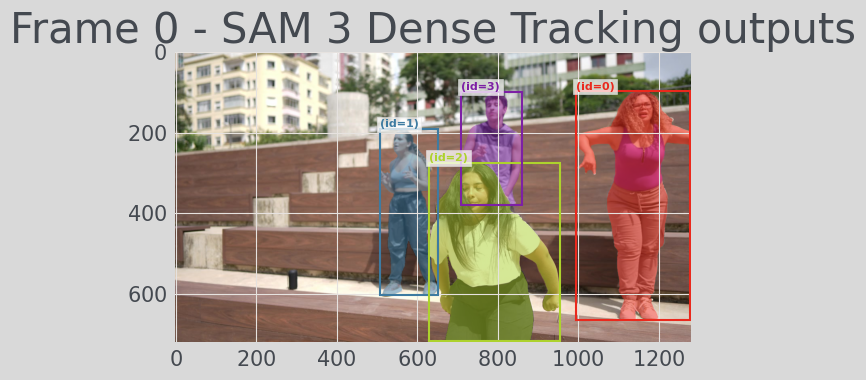

In [11]:
plt.close("all")
visualize_formatted_frame_output(
    frame_idx,
    image_files,
    outputs_list=[prepare_masks_for_visualization({frame_idx: out})],
    titles=["SAM 3 Dense Tracking outputs"],
    figsize=(6, 4),
)

In [12]:
# we will just propagate from frame 0 to the end of the video
outputs_per_frame = {}
for response in predictor.handle_stream_request(
    request=dict(
        type="propagate_in_video",
        session_id=session_id,
    )
):
    outputs_per_frame[response["frame_index"]] = response["outputs"]

outputs_per_frame = prepare_masks_for_visualization(outputs_per_frame)

INFO 2025-10-09 19:20:01,815 45261 sam3_video_predictor.py: 176: propagate in video in session e05b43a2-415c-4abb-abe0-58f4046e2478: propagation_direction='both', start_frame_idx=None, max_frame_num_to_track=None
INFO 2025-10-09 19:20:01,816 45727 sam3_video_predictor.py: 472: worker rank=3 received request request['type']='propagate_in_video'
INFO 2025-10-09 19:20:01,816 45727 sam3_video_predictor.py: 176: propagate in video in session e05b43a2-415c-4abb-abe0-58f4046e2478: propagation_direction='both', start_frame_idx=None, max_frame_num_to_track=None
INFO 2025-10-09 19:20:01,818 45261 sam3_video_inference.py:1073: Running full VG propagation (reverse=False).
INFO 2025-10-09 19:20:01,816 45727 sam3_video_inference.py:1073: Running full VG propagation (reverse=False).
INFO 2025-10-09 19:20:01,816 45729 sam3_video_predictor.py: 472: worker rank=5 received request request['type']='propagate_in_video'
INFO 2025-10-09 19:20:01,816 45729 sam3_video_predictor.py: 176: propagate in video in s

frame 180


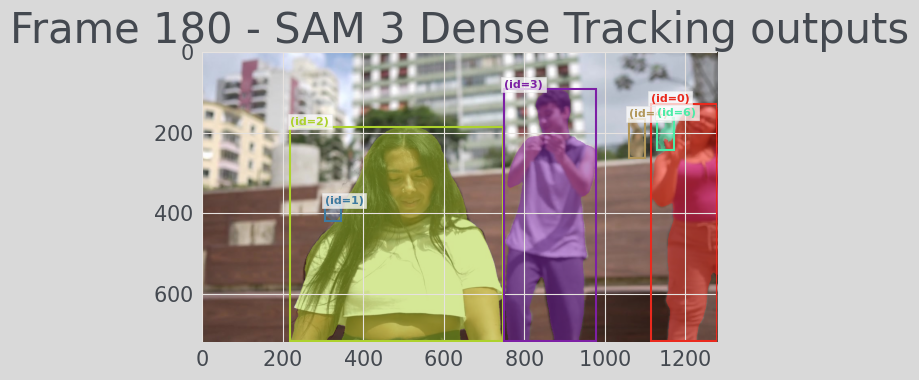

frame 240


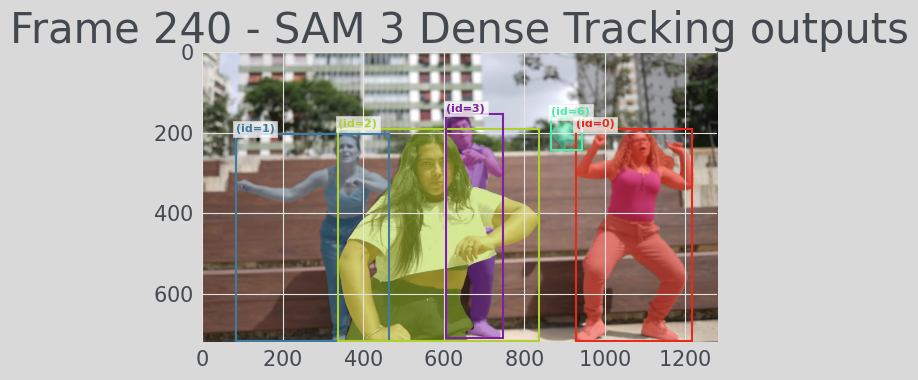

In [13]:
vis_frame_stride = 60
plt.close("all")
for frame_idx in range(0, len(outputs_per_frame), vis_frame_stride):
    print(f"frame {frame_idx}")
    visualize_formatted_frame_output(
        frame_idx,
        image_files,
        outputs_list=[outputs_per_frame],
        titles=["SAM 3 Dense Tracking outputs"],
        figsize=(6, 4),
    )

In [14]:
# finally, close the inference session to free its GPU resources
# (you may start a new session on another video)
_ = predictor.handle_request(
    request=dict(
        type="close_session",
        session_id=session_id,
    )
)

INFO 2025-10-09 19:20:10,833 45730 sam3_video_predictor.py: 472: worker rank=6 received request request['type']='close_session'
INFO 2025-10-09 19:20:10,834 45726 sam3_video_predictor.py: 472: worker rank=2 received request request['type']='close_session'
INFO 2025-10-09 19:20:10,834 45727 sam3_video_predictor.py: 472: worker rank=3 received request request['type']='close_session'
INFO 2025-10-09 19:20:10,835 45731 sam3_video_predictor.py: 472: worker rank=7 received request request['type']='close_session'
INFO 2025-10-09 19:20:10,835 45729 sam3_video_predictor.py: 472: worker rank=5 received request request['type']='close_session'
INFO 2025-10-09 19:20:10,835 45728 sam3_video_predictor.py: 472: worker rank=4 received request request['type']='close_session'
INFO 2025-10-09 19:20:10,835 45725 sam3_video_predictor.py: 472: worker rank=1 received request request['type']='close_session'
INFO 2025-10-09 19:20:11,040 45726 sam3_video_predictor.py: 237: removed session e05b43a2-415c-4abb-abe0

## 3. Clean up

In [15]:
# after all inference is done, we can shutdown the predictor
# to free up the multi-GPU process group
predictor.shutdown()

INFO 2025-10-09 19:20:11,202 45261 sam3_video_predictor.py: 495: shutting down 7 worker processes
INFO 2025-10-09 19:20:11,203 45725 sam3_video_predictor.py: 467: worker rank=1 shutting down
INFO 2025-10-09 19:20:11,204 45727 sam3_video_predictor.py: 467: worker rank=3 shutting down
INFO 2025-10-09 19:20:11,204 45731 sam3_video_predictor.py: 467: worker rank=7 shutting down
INFO 2025-10-09 19:20:11,204 45728 sam3_video_predictor.py: 467: worker rank=4 shutting down
INFO 2025-10-09 19:20:11,205 45730 sam3_video_predictor.py: 467: worker rank=6 shutting down
INFO 2025-10-09 19:20:11,205 45729 sam3_video_predictor.py: 467: worker rank=5 shutting down
INFO 2025-10-09 19:20:11,205 45726 sam3_video_predictor.py: 467: worker rank=2 shutting down
INFO 2025-10-09 19:20:11,665 45261 sam3_video_predictor.py: 501: shut down 7 worker processes
